In [2]:
from modules import *
from functions import *

In [ ]:
""" Funky orbit plot """

preferences_rad = np.deg2rad(preferences)*2

colors = vars
eo = 15

def plot_circular(trial=1):

    r = 1.8
    circle_angles = np.linspace(0, 2*np.pi, 100) 
    
    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

    for i in range(vars[::eo].shape[0]):
        ax.plot(-np.log(vars[::eo][i])**(-1) * np.cos(circle_angles), -np.log(vars[::eo][i])**(-1) * np.sin(circle_angles), color='k', alpha=0.1)
        # ax.plot(np.cos(circle_angles), np.sin(circle_angles), color='k', alpha=0.3)

    sc = ax.scatter(-np.log(vars[::eo])**(-1) * np.cos(preferences_rad[::eo, trial]), -np.log(vars[::eo])**(-1) * np.sin(preferences_rad[::eo, trial]), c=colors[::eo], cmap='RdYlBu_r', ec='k', lw=0.5, s=20, zorder=3, alpha=1, norm=LogNorm())

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.3)
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label('Learning rate', rotation=270, labelpad=20)

    limit = np.max(np.log(vars[::eo][i])**(-1)) + 0.52
    ax.text(limit , -0.03, '0', fontsize=10)
    ax.text(-0.02, limit, '45', fontsize=10)
    ax.text(-limit-0.05, -0.03, '90', fontsize=10)
    ax.text(-0.03, -limit-0.04, '135', fontsize=10)

    # polygon = Polygon(np.array([[-1.6, 0.07], [-1.4, 0], [-1.6, -0.07]]), closed=False, color='firebrick', lw=0.5)
    # ax.add_patch(polygon)

    # ax.set_xlim(-r, r); ax.set_ylim(-r, r)
    ax.axis('off')
    ax.axis('equal')
    plt.show()

interact(plot_circular, trial=(0, n_trials-1));

In [ ]:
""" Tuning curve width versus Hebbian / random tradeoff """

def get_FWHM(rand_scaling, hebb_scaling, n_repeats):

    mean_FWHMs = []
    var_FWHMs = []
    for repeat in range(n_repeats):
            
        # Set initial weights
        W_init = ori_matrix(1, 10) / N  
        W_init /= np.sum(W_init, axis=0)

        W = np.zeros((N, N, n_trials+1))
        W[:, :, 0] = W_init

        # Run trials
        for trial in range(n_trials):
            thetas = np.random.choice(180, size=n_thetas, replace=True)
            w = W[:, :, trial]
            delta_ws = []
            for i in range(n_thetas):
                # theta = theta_stim  
                theta = thetas[i]
                y = circular_gaussian(N, theta, amp=1, sigma=60, baseline=0) 
                post = w.T.dot(y) 
                hebbian_comp = np.outer(y, post) 
                delta_ws.append(hebbian_comp)

            W_old = W[:, :, trial]
            random = np.random.randn(N, N) * rand_scaling
            sum_deltas = np.sum(np.array(delta_ws), axis=0) * hebb_scaling
            prop_hebb = propensity_hebb(W_old, a)  # 50   higher -> higher weights have less Hebbian influence
            prop_rand = propensity_rand(W_old, b)  # 50   lower -> lower weights have less random influence;  higher -> allow lower weights to also have intrinsic fluctuations
            
            W_new = W_old + (prop_hebb * sum_deltas + prop_rand * random) * vars
            W_new[W_new < 0] = 0
            W_new /= np.sum(W_new, axis=0) + 1e-10

            neuron_disconnected = np.where(~W_new.any(axis=0))[0]
            if neuron_disconnected.size > 0:
                W_new[np.random.randint(0, N, neuron_disconnected.size), neuron_disconnected] = np.random.uniform(0.01, 0.05, neuron_disconnected.shape)  # if all incoming weights are zero, insert a new synapse on the diagonal 
            
            # n_rand_insert = int(N/10)
            # W_new[np.random.randint(0, N, n_rand_insert), np.random.randint(0, N, n_rand_insert)] = np.random.uniform(0.01, 0.1, n_rand_insert)   # random birth of synapses
            
            W[:, :, trial+1] = W_new

        W_final = W[:, :, -1]
        n_angles = 100
        posts = get_tuning_curve(N, W_final, n_angles).T
        FWHMs = [FWHM(N, posts[:, x], n_angles) for x in range(N)]

        mean_FWHMs.append(np.mean(FWHMs))
        var_FWHMs.append(np.var(FWHMs))

    return np.mean(mean_FWHMs), np.mean(var_FWHMs)

##########################################################################################

N = int(500)     
n_trials = 20
n_thetas = 5
theta_stim = 90
vars = np.random.lognormal(-3, 1.5, N) 
init_trials = 10
a=50       
b=30

n_repeats = 1

nx = 2
ny = 2
hebb_scaling_max = 1
rand_scaling_max = 1

mean_FWHM_matrix = np.zeros((ny, nx)); variance_FWHM_matrix = np.zeros((ny, nx))

for i, rand_scaling in enumerate(tqdm(np.linspace(0, rand_scaling_max, ny))):
    for j, hebb_scaling in enumerate(np.linspace(0, hebb_scaling_max, nx)):
        mean_FWHM_matrix[i, j], variance_FWHM_matrix[i, j] = get_FWHM(rand_scaling, hebb_scaling, n_repeats)



100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


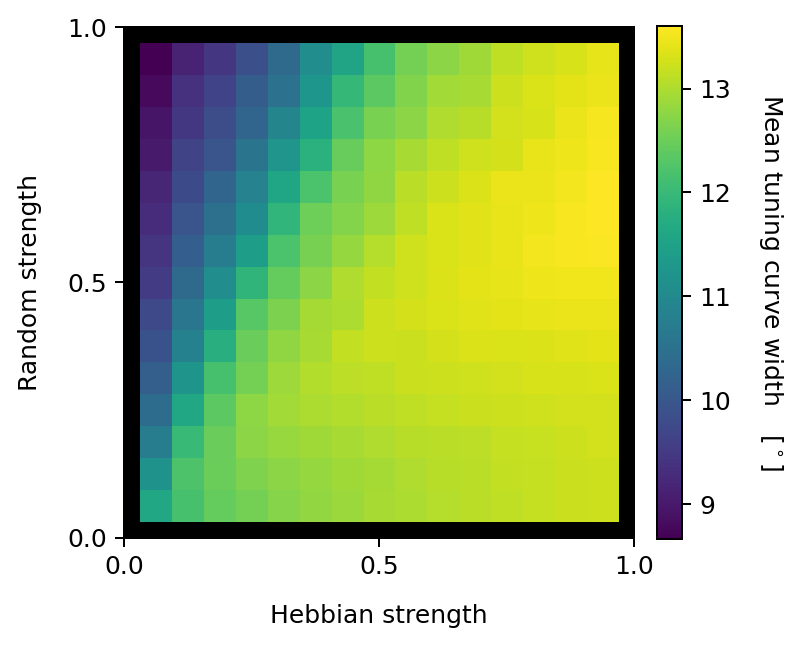

In [ ]:
n_ticks = 3

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=180)
ax.imshow(mean_FWHM_matrix, cmap='viridis') #, vmin=0, vmax=10)
cbar = fig.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'Mean tuning curve width $ \;  \; \; [^\circ]$', rotation=-90, va="bottom") #, fontweight='bold')
ax.set_xlabel(r'Hebbian strength', labelpad=10)
ax.set_ylabel(r'Random strength', labelpad=10)
ax.set_xticks(np.linspace(-1, nx, n_ticks))
ax.set_xticklabels(np.round(np.linspace(0, hebb_scaling_max, n_ticks), 2))
ax.set_yticks(np.linspace(-1, ny, n_ticks))
ax.set_yticklabels(np.round(np.linspace(0, rand_scaling_max, n_ticks), 2))
ax.invert_yaxis()
ax.set_facecolor('k')


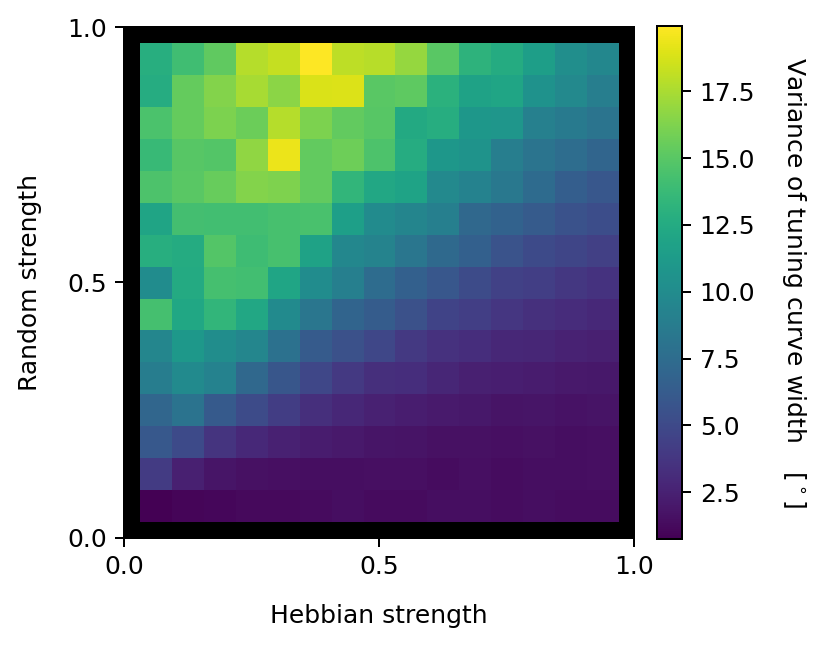

In [ ]:
n_ticks = 3

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=180)
ax.imshow(variance_FWHM_matrix) #, vmin=0, vmax=10)
cbar = fig.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'Variance of tuning curve width $ \;  \; \; [^\circ]$', rotation=-90, va="bottom") #, fontweight='bold')
ax.set_xlabel(r'Hebbian strength', labelpad=10)
ax.set_ylabel(r'Random strength', labelpad=10)
ax.set_xticks(np.linspace(-1, nx, n_ticks))
ax.set_xticklabels(np.round(np.linspace(0, hebb_scaling_max, n_ticks), 2))
ax.set_yticks(np.linspace(-1, ny, n_ticks))
ax.set_yticklabels(np.round(np.linspace(0, rand_scaling_max, n_ticks), 2))
ax.invert_yaxis()
ax.set_facecolor('k')


In [ ]:
def get_FWHM_distribution(rand_scaling, hebb_scaling, n_repeats):

    all_FWHMs = []
    for repeat in range(n_repeats):
            
        # Set initial weights
        W_init = ori_matrix(1, 10) / N  
        W_init /= np.sum(W_init, axis=0)

        W = np.zeros((N, N, n_trials+1))
        W[:, :, 0] = W_init

        # Run trials
        for trial in range(n_trials):
            thetas = np.random.choice(180, size=n_thetas, replace=True)
            w = W[:, :, trial]
            delta_ws = []
            for i in range(n_thetas):
                # theta = theta_stim  
                theta = thetas[i]
                y = circular_gaussian(theta, amp=1, sigma=60, baseline=0) 
                post = w.T.dot(y) 
                hebbian_comp = np.outer(y, post) 
                delta_ws.append(hebbian_comp)

            W_old = W[:, :, trial]
            random = np.random.randn(N, N) * rand_scaling
            sum_deltas = np.sum(np.array(delta_ws), axis=0) * hebb_scaling
            prop_hebb = propensity_hebb(W_old, a)  # 50   higher -> higher weights have less Hebbian influence
            prop_rand = propensity_rand(W_old, b)  # 50   lower -> lower weights have less random influence;  higher -> allow lower weights to also have intrinsic fluctuations
            
            W_new = W_old + (prop_hebb * sum_deltas + prop_rand * random) * vars
            W_new[W_new < 0] = 0
            W_new /= np.sum(W_new, axis=0) + 1e-10

            neuron_disconnected = np.where(~W_new.any(axis=0))[0]
            if neuron_disconnected.size > 0:
                W_new[np.random.randint(0, N, neuron_disconnected.size), neuron_disconnected] = np.random.uniform(0.01, 0.05, neuron_disconnected.shape)  # if all incoming weights are zero, insert a new synapse on the diagonal 
            
            # n_rand_insert = int(N/10)
            # W_new[np.random.randint(0, N, n_rand_insert), np.random.randint(0, N, n_rand_insert)] = np.random.uniform(0.01, 0.1, n_rand_insert)   # random birth of synapses
            
            W[:, :, trial+1] = W_new

        W_final = W[:, :, -1]
        n_angles = 100
        posts = get_tuning_curve(W_final, n_angles).T
        FWHMs = [FWHM(posts[:, x], n_angles) for x in range(N)]

        all_FWHMs.append(FWHMs)

    return np.mean(all_FWHMs, axis=0)

In [ ]:
rand_scaling = 0.7
hebb_scaling = 0.3
n_repeats = 1

FWHMs = get_FWHM_distribution(rand_scaling, hebb_scaling, n_repeats)

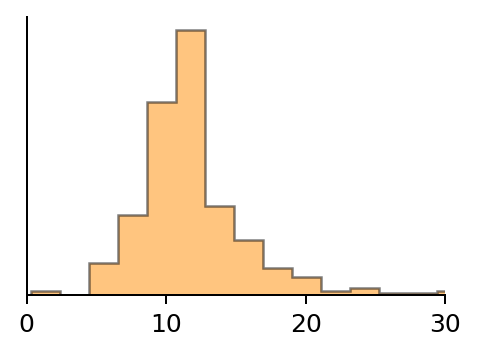

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=180)

ax.hist(FWHMs, bins=20, color='darkorange', ec='k', histtype='stepfilled', alpha=0.5)

ax.set_xlim(0, 30)

# ax.set_xlabel(r'Tuning curve width $  \; \; [^\circ]$', labelpad=10)
# turn off y labels
ax.set_yticks([])
sns.despine()

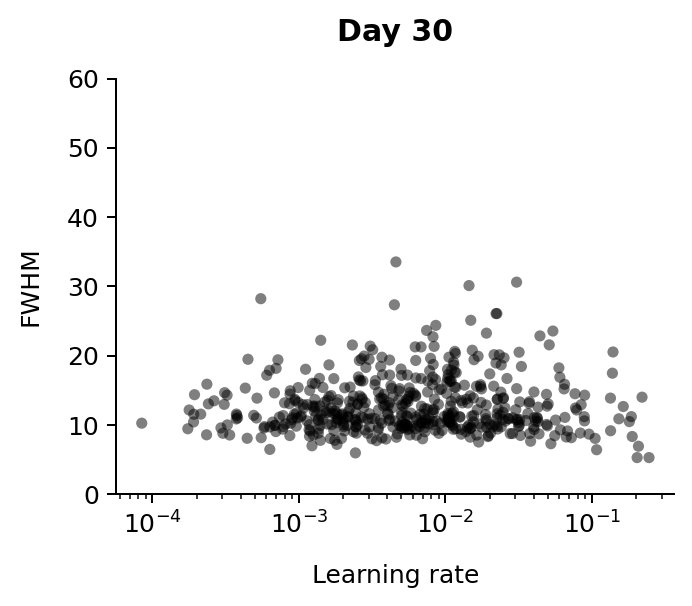

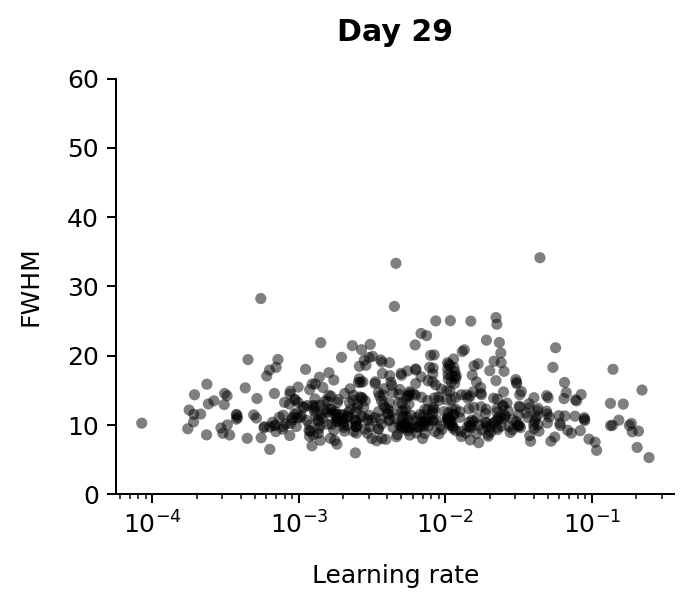

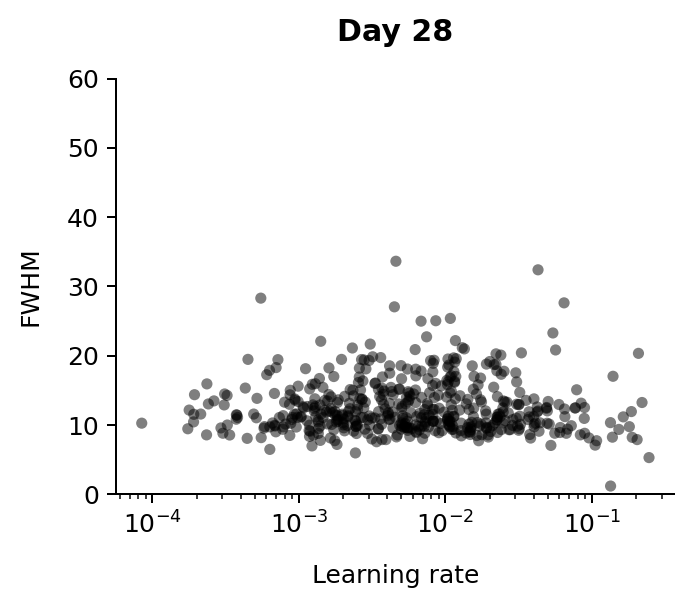

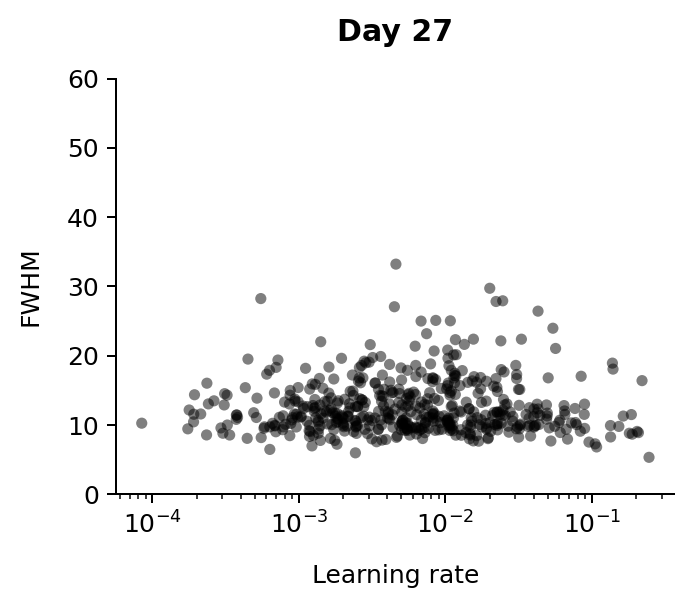

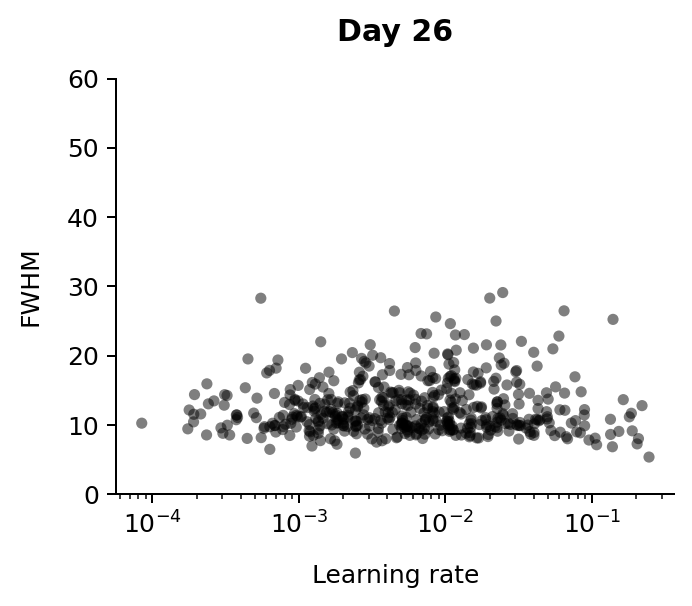

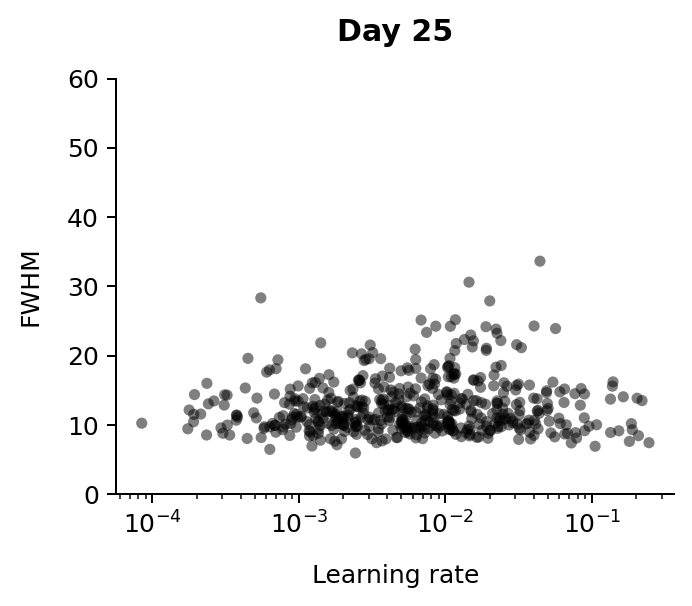

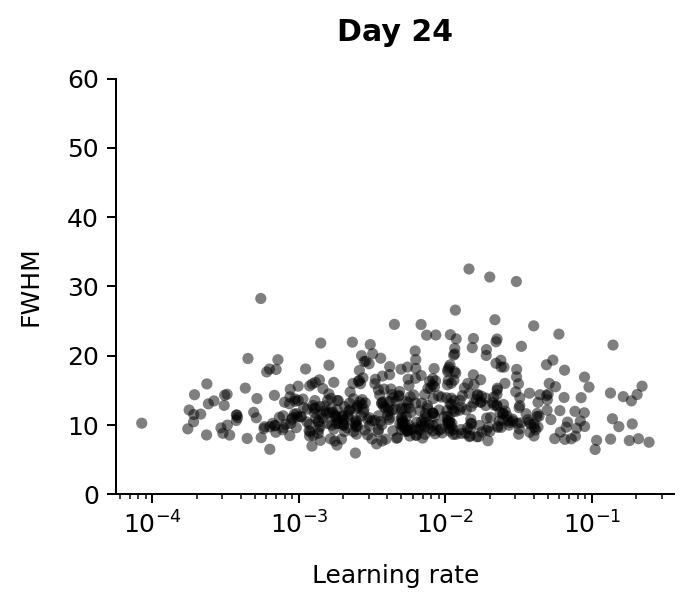

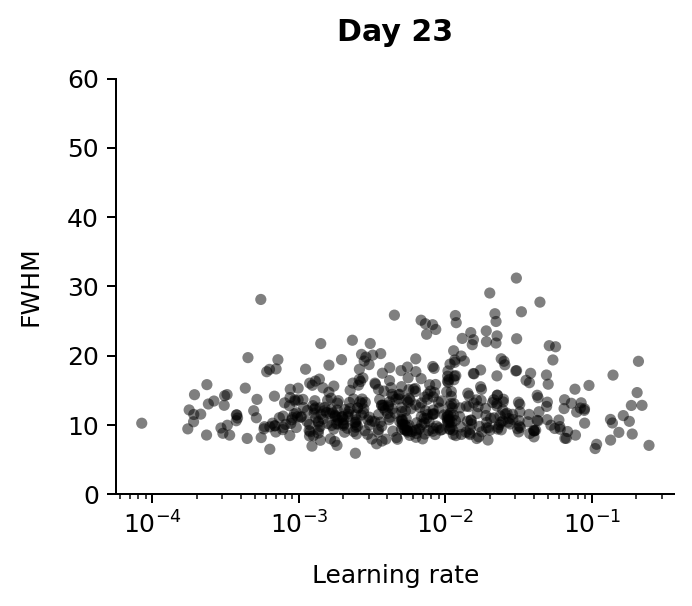

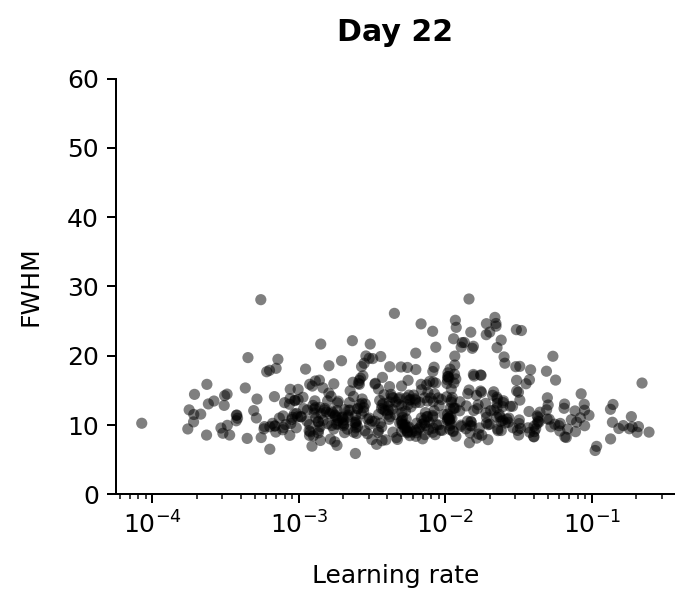

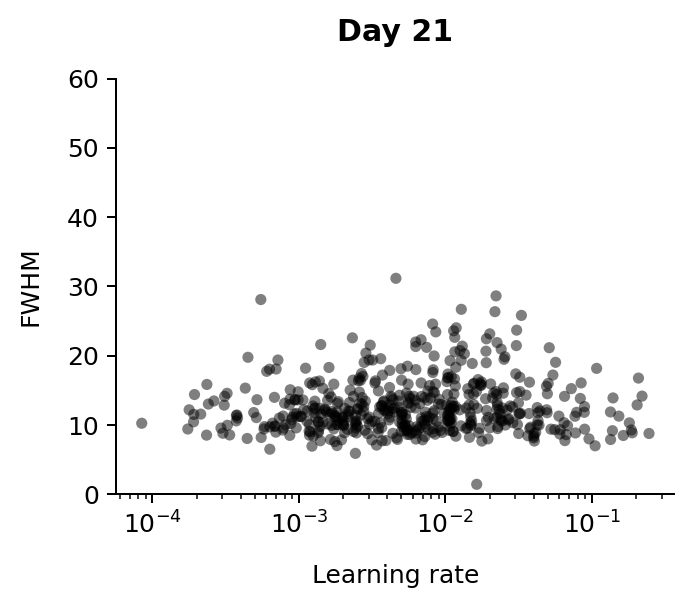

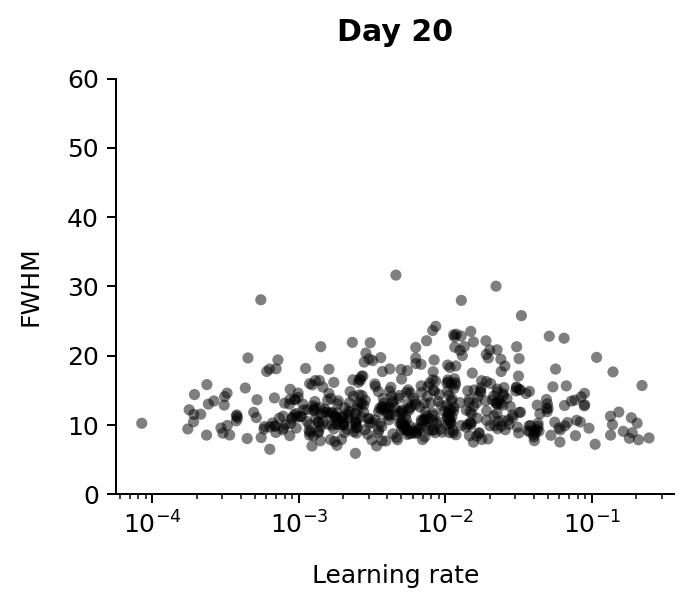

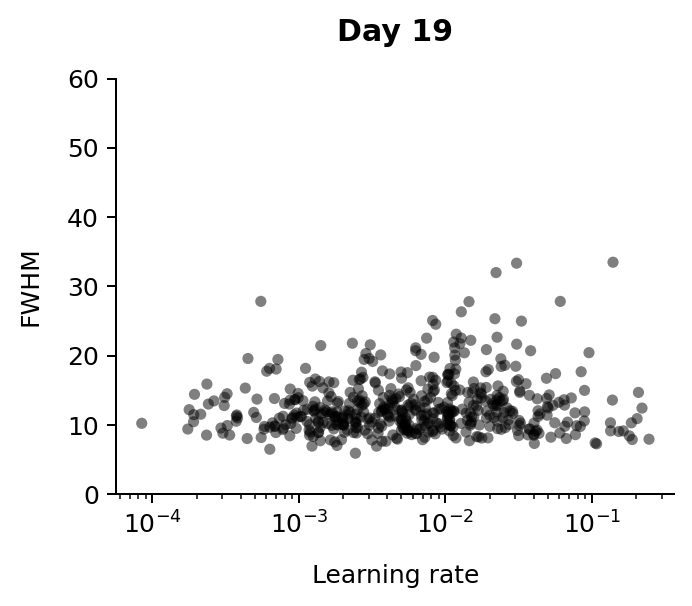

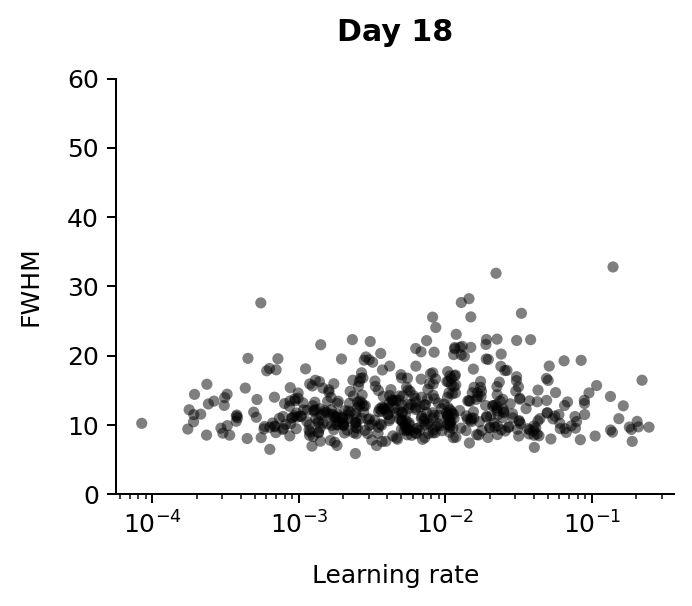

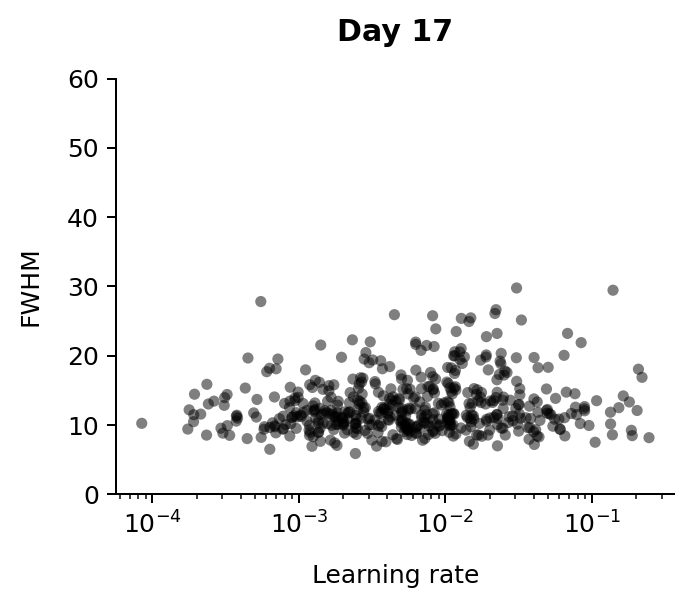

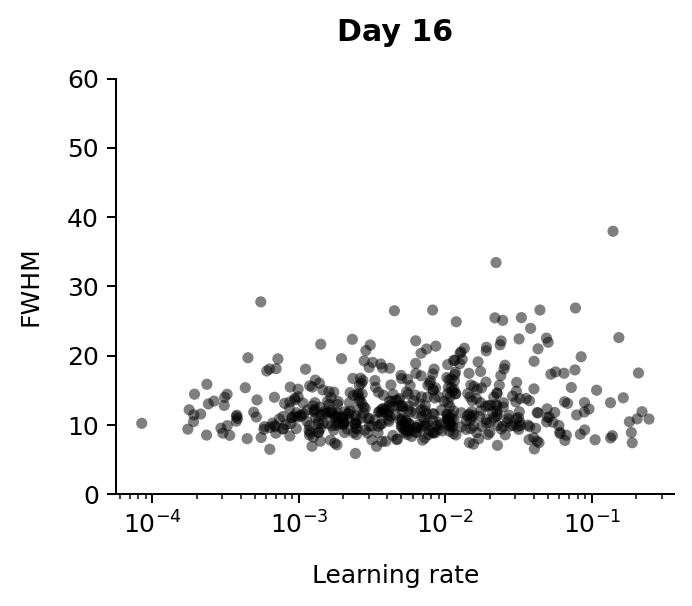

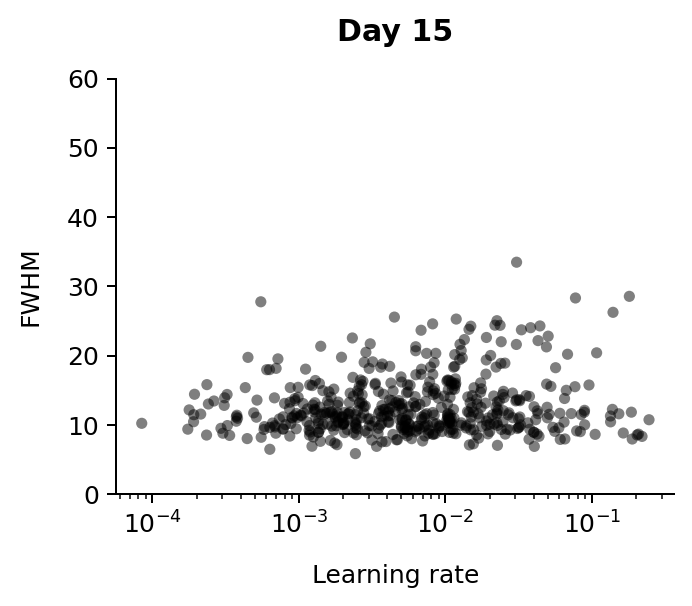

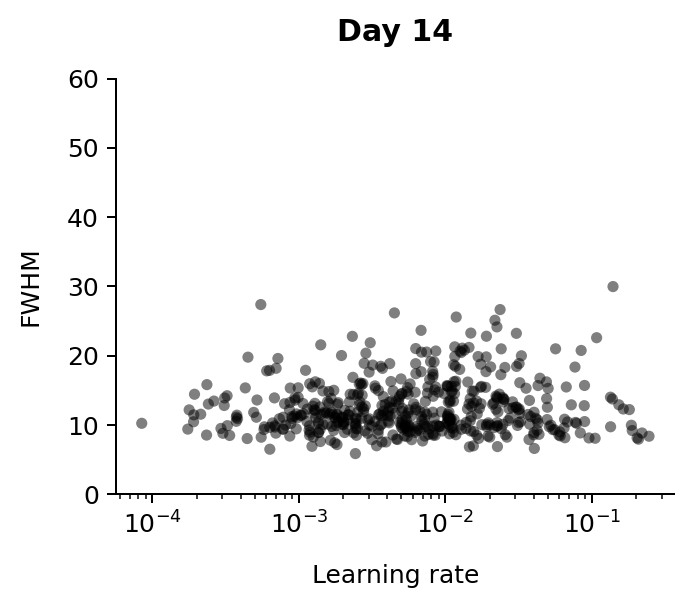

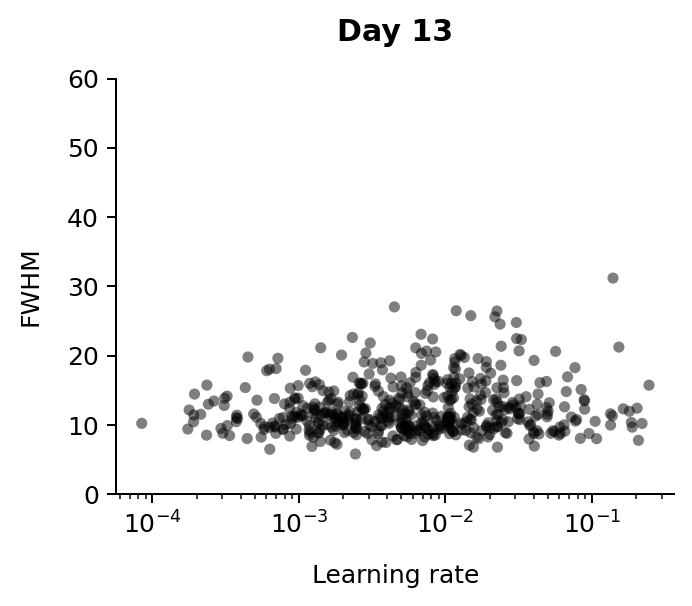

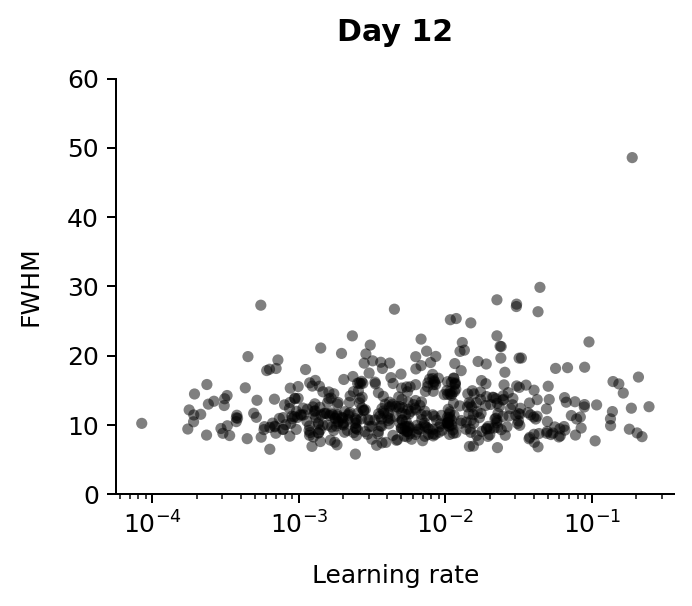

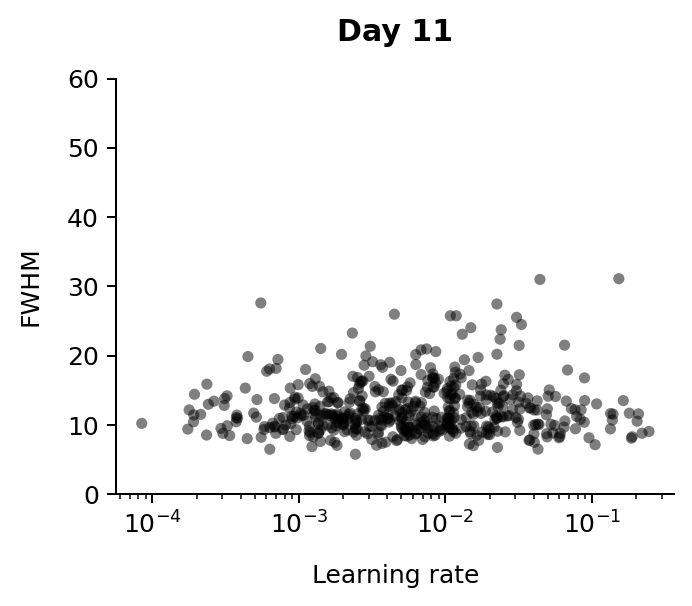

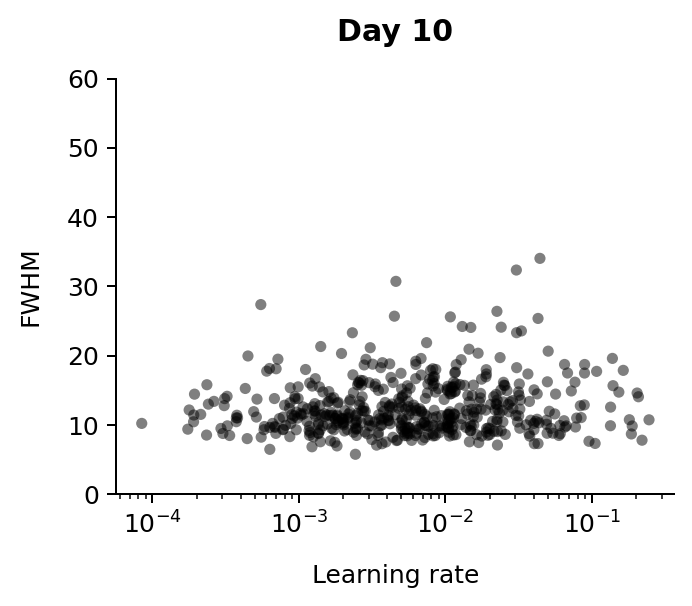

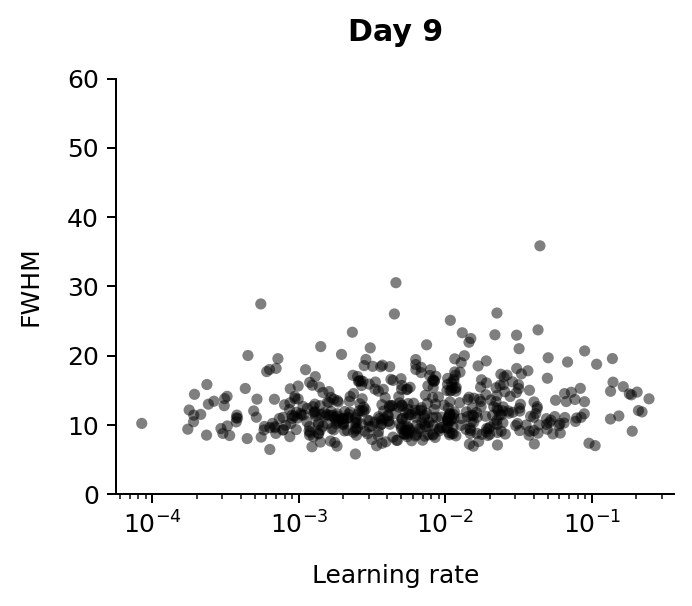

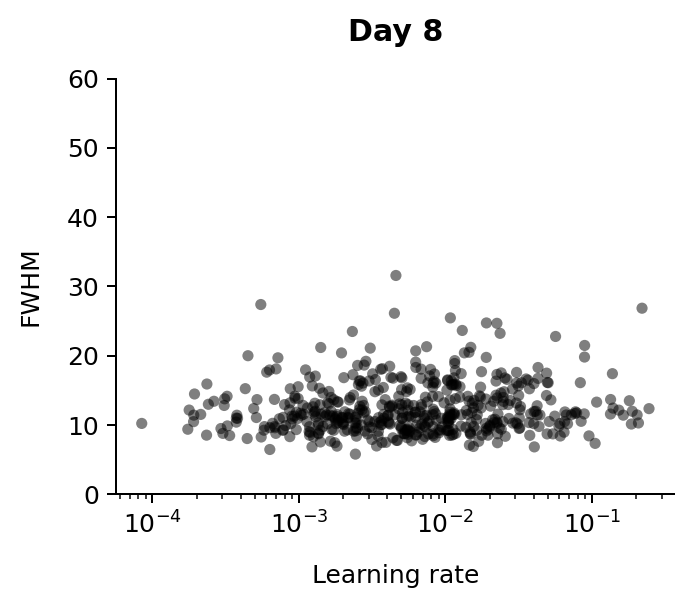

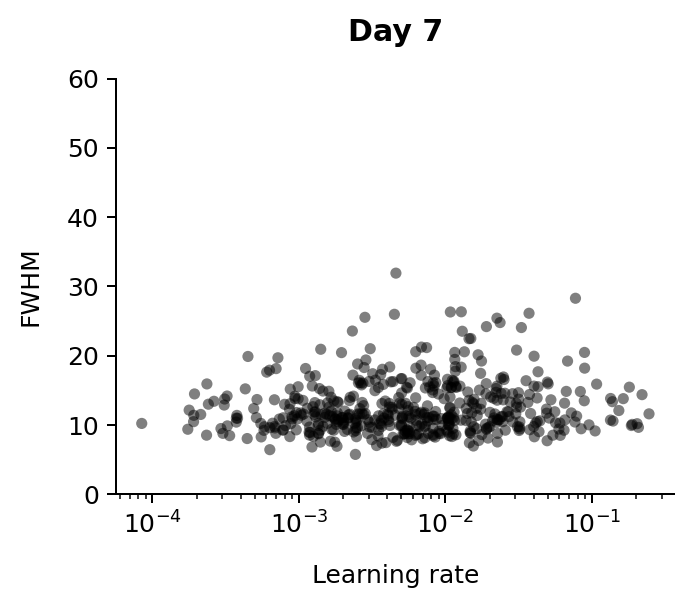

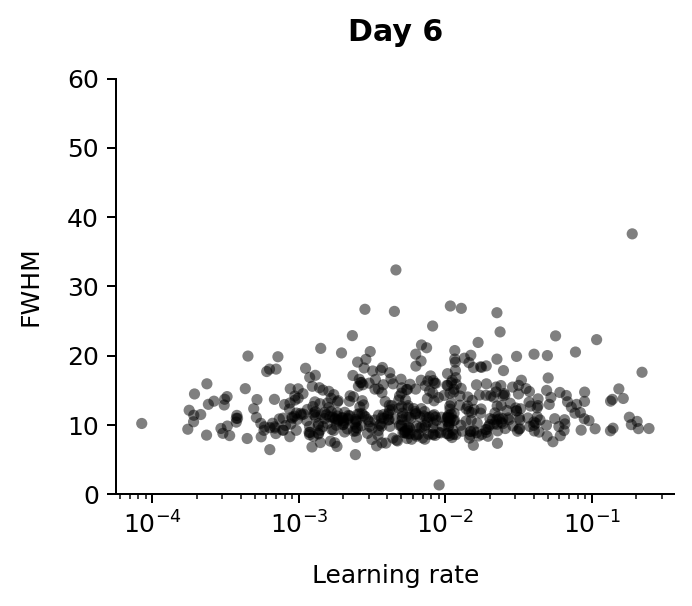

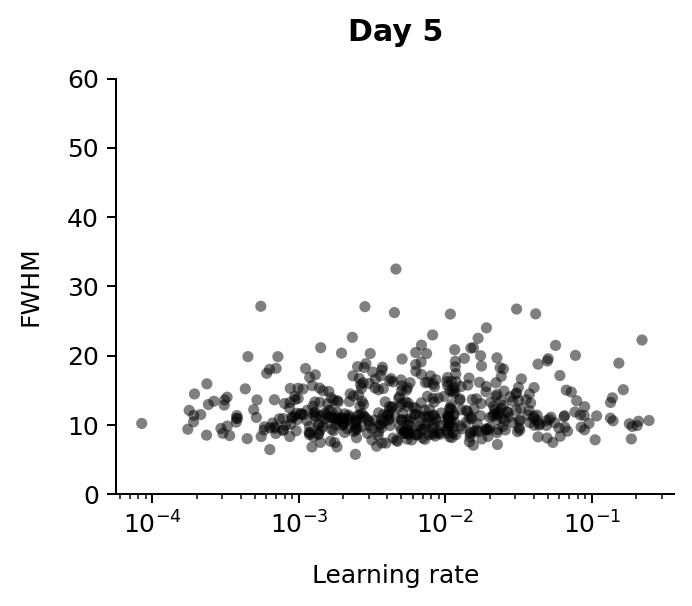

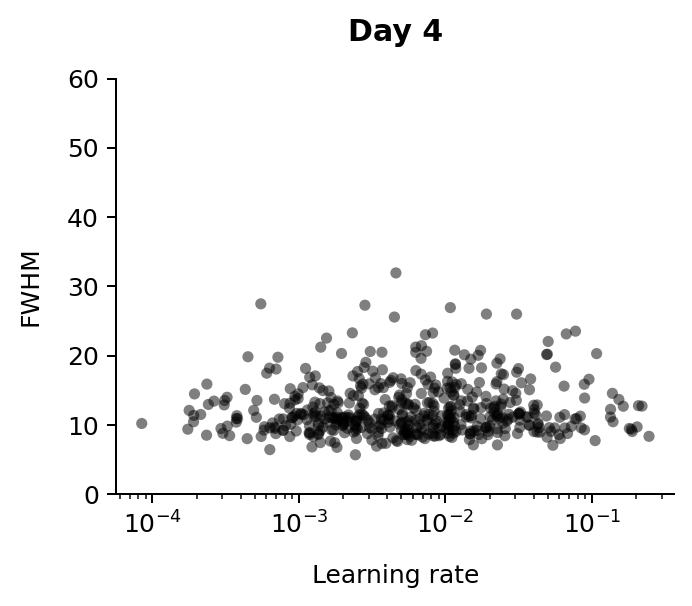

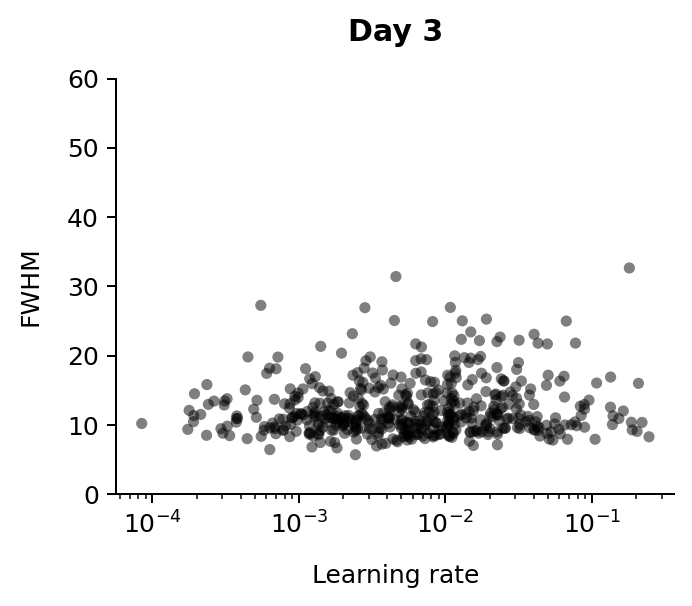

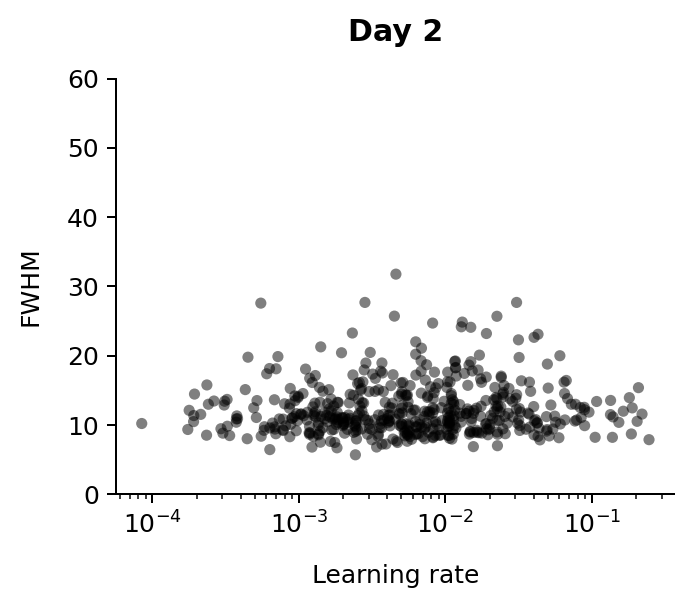

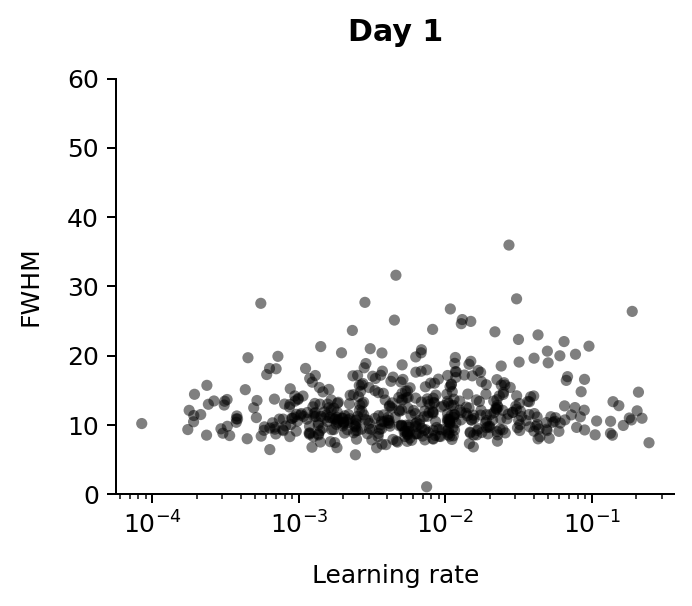

In [ ]:
""" Full width half maximum vs. learning rate """

for v in range(1, n_trials+1):

    W_final = W[:, :, -v]

    n_angles = 100

    posts = get_tuning_curve(W_final, n_angles).T
    FWHMs = [FWHM(posts[:, x], n_angles) for x in range(N)]

    fig, ax = plt.subplots(figsize=(4,3), dpi=180)

    ax.scatter(vars, FWHMs, s=20, alpha=0.5, fc='k', ec=None)
    ax.set_xscale('log')
    ax.set_ylim(0, 60)
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('FWHM')
    ax.set_title('Day {}'.format(n_trials-v+1), fontsize=12, fontweight='bold', pad=15)
    sns.despine()
    plt.show()
    
    fig.savefig('FWHM_vs_learning_rate_{}.png'.format(n_trials-v+1), dpi=180, bbox_inches='tight')